In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# comment

In [2]:
df_month_data = pd.read_csv("Cst_to_U.csv",index_col=False,encoding="utf-8")

In [3]:
def create_adjacency_matrix(df):
    """
    Create an adjacency matrix for stations based on travel records.
    
    Parameters:
    df (DataFrame): DataFrame containing travel records with 'Depature station' and 'Arrival station' columns
    
    Returns:
    tuple: (adjacency_matrix, station_names)
    """
    # Extract all unique stations (both departure and arrival)
    departure_stations = df['Avgångsplats'].unique()
    arrival_stations = df['Ankomstplats'].unique()
    all_stations = np.unique(np.concatenate([departure_stations, arrival_stations]))
    
    # Create a mapping of station names to indices
    station_to_index = {station: i for i, station in enumerate(all_stations)}
    
    # Initialize the adjacency matrix with zeros
    n_stations = len(all_stations)
    adjacency_matrix = np.zeros((n_stations, n_stations))
    
    # Fill the adjacency matrix
    for _, row in df.iterrows():
        from_station = row['Avgångsplats']
        to_station = row['Ankomstplats']
        
        # Get indices for the stations
        from_idx = station_to_index[from_station]
        to_idx = station_to_index[to_station]
        
        # Set the connection in the adjacency matrix
        adjacency_matrix[from_idx, to_idx] = 1
    
    return adjacency_matrix, all_stations

In [4]:
def plot_adjacency_matrix(adj_matrix, station_names):
    """
    Plot the adjacency matrix using seaborn heatmap.
    
    Parameters:
    adj_matrix (numpy.ndarray): The adjacency matrix
    station_names (list): List of station names
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(adj_matrix, cmap='Blues', 
                xticklabels=station_names, 
                yticklabels=station_names,
                linewidths=0.5,
                linecolor='lightgray')
    plt.title('Station Connectivity Adjacency Matrix')
    plt.xlabel('To Station')
    plt.ylabel('From Station')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [5]:
adj_max, all_stations = create_adjacency_matrix(df_month_data)


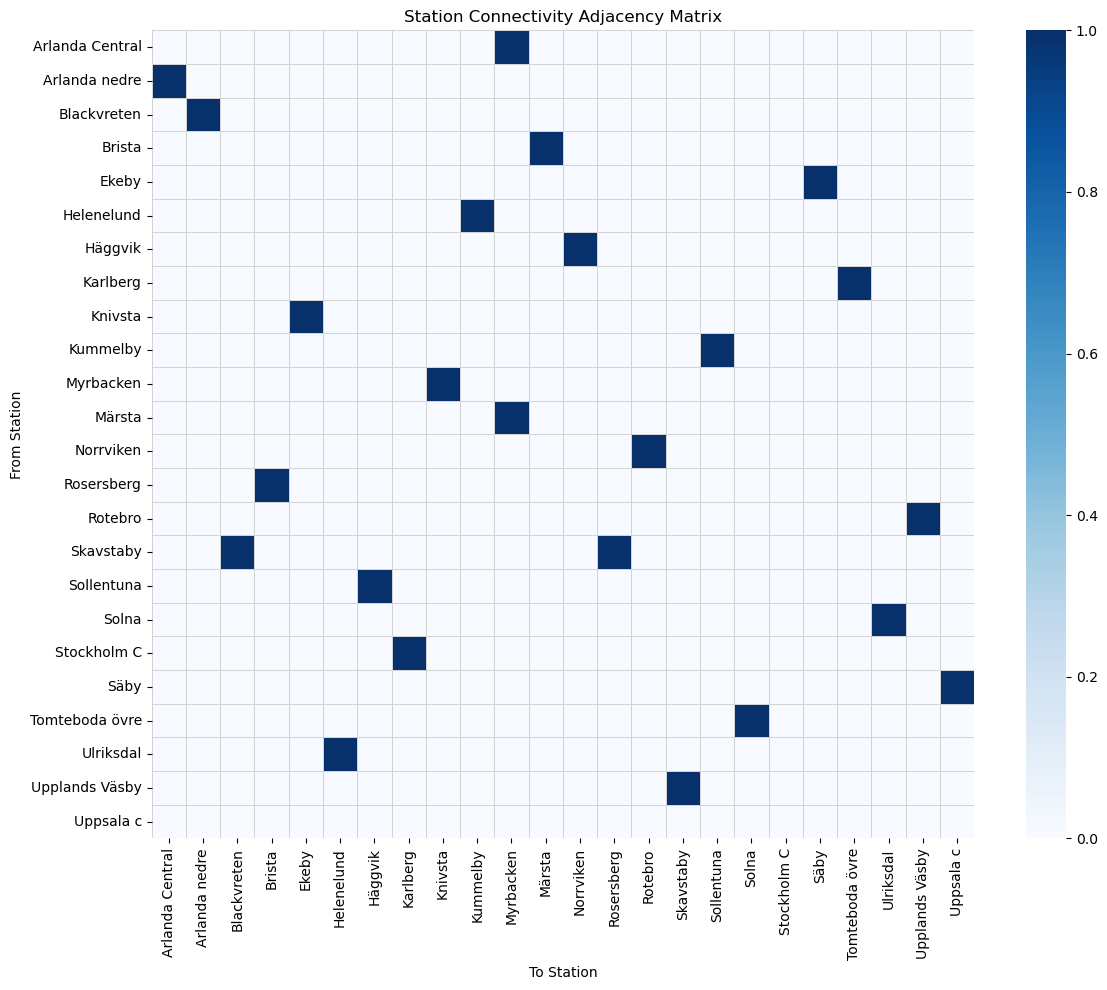

In [6]:
plot_adjacency_matrix(adj_max, all_stations)

In [21]:
def create_delay_adjacency_matrix(df,alpha, adjacency_matrix, station_names):
    """
    Create an adjacency matrix with average delay times between connected stations.
    
    Parameters:
    df (DataFrame): DataFrame containing travel records with 'Depature station', 'Arrival station', and 'AvgFörsening' columns
    adjacency_matrix (numpy.ndarray): Existing adjacency matrix showing connections (1 for connected, 0 for not connected)
    station_names (list): List of station names corresponding to the adjacency matrix indices
    
    Returns:
    numpy.ndarray: Adjacency matrix with average delay times
    """
    # Create a mapping of station names to indices
    station_to_index = {station: i for i, station in enumerate(station_names)}
    
    # Initialize delay matrix with NaN values (for stations that are not connected)
    n_stations = len(station_names)
    delay_matrix = np.full((n_stations, n_stations), np.nan)
    
    # For each pair of connected stations in the adjacency matrix
    for i in range(n_stations):
        for j in range(n_stations):
            if adjacency_matrix[i, j] == 1:
                # Get the station names
                from_station = station_names[i]
                to_station = station_names[j]
                
                # Filter the dataframe for records between these two stations
                mask = (df['Avgångsplats'] == from_station) & (df['Ankomstplats'] == to_station)
                relevant_records = df[mask]
                records_higher_than_threshold = relevant_records[relevant_records['AvgFörsening'] > alpha]

                
                # If there are records, calculate the average delay
                if len(records_higher_than_threshold) > 0:
                    avg_delay = records_higher_than_threshold['AvgFörsening'].mean()
                    delay_matrix[i, j] = avg_delay
                else:
                    # If no records found, keep as NaN
                    delay_matrix[i, j] = np.nan
    
    return delay_matrix

In [20]:
def plot_delay_matrix(delay_matrix, station_names, cmap='coolwarm', title='Average Delay Between Stations (minutes)'):
    """
    Plot the delay adjacency matrix using seaborn heatmap.
    
    Parameters:
    delay_matrix (numpy.ndarray): Matrix containing average delay times
    station_names (list): List of station names
    cmap (str): Colormap to use for the heatmap
    title (str): Title for the plot
    """
    plt.figure(figsize=(14, 12))
    mask = np.isnan(delay_matrix)  # Create a mask for NaN values
    
    # Plot the heatmap with the mask to show only connected stations
    sns.heatmap(delay_matrix, 
                mask=mask,
                cmap=cmap, 
                xticklabels=station_names, 
                yticklabels=station_names,
                annot=True,  # Show values in cells
                fmt='.1f',
                linewidths=0.5,
                linecolor='lightgray')   # Format to 1 decimal place
    
    plt.title(title)
    plt.xlabel('To Station')
    plt.ylabel('From Station')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [22]:
alpha = 0.9
delay_adj_matrix = create_delay_adjacency_matrix(df_month_data,alpha,adj_max,all_stations.tolist())

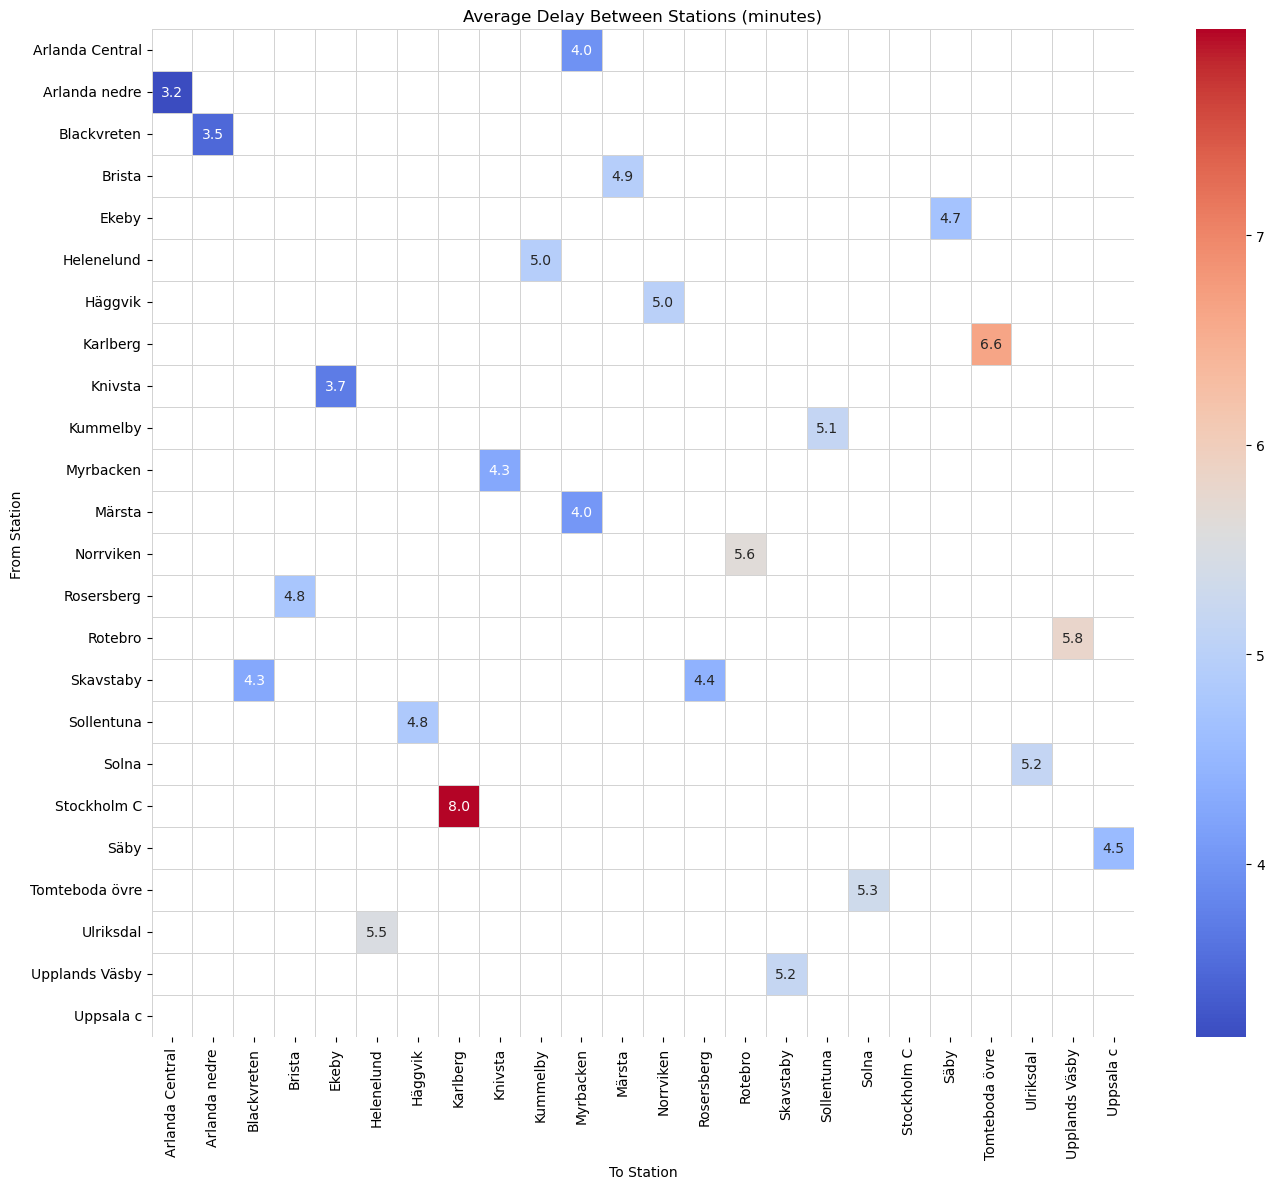

In [23]:
plot_delay_matrix(delay_adj_matrix, all_stations.tolist(), cmap='coolwarm', title='Average Delay Between Stations (minutes)')